In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry,CircularAnnulus,CircularAperture
from photutils import DAOStarFinder

In [2]:
image = 'HOROLOGIUM-I_f814w/crClean/jdan21llq_WJ2.fits'

hdu = fits.open(image)
sci_814 = hdu[0].data
hdu.close()

B`BZ?mBI?&B^ugBd??Bb??B{?
B?Q?Brz?B`??Bm??Bi,[Bq?VBZv?Bh?B??uBn/?BnNBf??Bw? [astropy.io.fits.card]
PREEND                                                                           [astropy.io.fits.card]


In [35]:
im2 = 'HOROLOGIUM-I_f814w/jdan21llq_flc.fits'

hdu = fits.open(image)
hdr_814 = hdu[0].header
hdu.close()

In [36]:
hdr_814['exptime']

1122.0

In [3]:
data_814 = sci_814.copy()

In [4]:
mean_814, median_814, std_814 = sigma_clipped_stats(data_814, sigma=3.0, \
                                            maxiters=5)

In [5]:
daofind_814 = DAOStarFinder(fwhm=2.5, threshold=5.*std_814)
sources_814 = daofind_814(data_814 - median_814)

In [6]:
loc_814 = np.array([sources_814['xcentroid'], sources_814['ycentroid']])
positions_814 = np.transpose(loc_814)

In [7]:
print(len(sources_814))

8485


In [8]:
apertures_r4_814 = CircularAperture(positions_814, r=4.)
rawflux_r4_814 = aperture_photometry(data_814, apertures_r4_814)

In [9]:
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground,SExtractorBackground

In [10]:
sigma_clip = SigmaClip(sigma=2.5)
bkg_estimator = SExtractorBackground()
bkg = Background2D(data_814,(50,50),filter_size=(3,3), sigma_clip=sigma_clip,\
                  bkg_estimator=bkg_estimator)

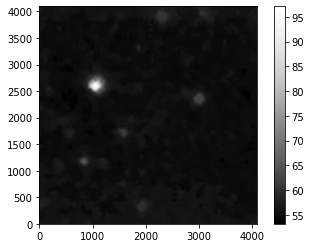

In [13]:
plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
plt.colorbar()

In [14]:
annulus_apertures_814 = CircularAnnulus(positions_814, r_in=9., \
                                        r_out=12.)

In [15]:
annulus_masks = annulus_apertures_814.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    
    annulus_data = mask.multiply(data_814)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median_814 = np.array(bkg_median)

In [16]:
rawflux_r4_814['annulus_median'] = bkg_median_814
print(rawflux_r4_814['annulus_median'][:10])

annulus_median
--------------
          38.0
          35.0
          39.0
          43.0
          36.0
          44.5
          42.0
          41.0
          35.5
          42.5


In [17]:
rawflux_r4_814['aper_bkg'] = bkg_median_814*apertures_r4_814.area
print(rawflux_r4_814['aper_bkg'][:10])

     aper_bkg     
------------------
 1910.088333382594
 1759.291886010284
1960.3538158400308
2161.4157456697776
1809.5573684677208
 2236.813969355933
 2111.150263212341
 2060.884780754904
1784.4246272390026
2136.2830044410593


In [18]:
rawflux_r4_814['final_phot'] = rawflux_r4_814['aperture_sum'] \
    - rawflux_r4_814['aper_bkg']

In [19]:
EEVband = 0.839 #4 pix rad
EEIband  = 0.830 #4 pix rad

ZPV = 26.667
ZPI = 26.779

# ZPV = 21.1
# ZPI = 21.1

In [20]:
mask_negative = (rawflux_r4_814['final_phot'] > 0) 
rawflux_pos_r4_814 = rawflux_r4_814[mask_negative]

In [31]:
final_phot_814 = -2.5*np.log10(rawflux_pos_r4_814['final_phot']/EEIband) \
    +2.5*np.log10(hdr_814['exptime']) + ZPI
print(final_phot_814[:10])

    final_phot    
------------------
  26.8311484543144
27.998992655749568
30.175947202355076
28.410481747971268
 27.92761860773747
27.093956663249543
 25.35841400834957
26.991697125033664
 25.81860250228724
 26.51640101244306


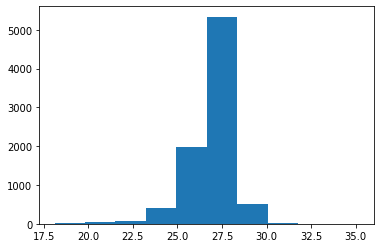

In [32]:
plt.hist(final_phot_814)
plt.show()

In [34]:
rawflux_pos_r4_814['magr'] = final_phot_814
s0 = ' '
header = s0.join(rawflux_pos_r4_814.dtype.names)
print(header)

id xcenter ycenter aperture_sum annulus_median aper_bkg final_phot magr


In [ ]:
np.savetxt('photUtils0820/starFinder_F814W.dat',rawflux_pos_r4_814,header=header)